In [1]:
# Load libraries
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import metrics
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import math
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans, DBSCAN

In [2]:
# Get training and testing data
train_data = pd.read_csv('train_data.csv', delimiter='\t', index_col=0)
test_data  = pd.read_csv('test_data.csv',  delimiter='\t', index_col=0)
# Drop ID, chocolate, the ficticious drug Semer, and legal substances
train_data.drop(columns=['ID', 'Choc', 'Semer', 'Alcohol', 'Nicotine', 'Caff', 'Legalh'], inplace=True)
test_data.drop (columns=['ID', 'Choc', 'Semer', 'Alcohol', 'Nicotine', 'Caff', 'Legalh'], inplace=True)

# Convert categories to integers
for column in train_data.loc[:, 'Amphet':]:
    train_data[column] = train_data[column].astype('category').cat.codes
    train_data[column] = train_data[column].astype('int32')
for column in test_data.loc[:, 'Amphet':]:
    test_data[column]  = test_data[column].astype('category').cat.codes
    test_data[column]  = test_data[column].astype('int32')

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319 entries, 1287 to 684
Data columns (total 25 columns):
Age          1319 non-null float64
Gender       1319 non-null float64
Education    1319 non-null float64
Country      1319 non-null float64
Ethnicity    1319 non-null float64
Nscore       1319 non-null float64
Escore       1319 non-null float64
Oscore       1319 non-null float64
Ascore       1319 non-null float64
Cscore       1319 non-null float64
Impulsive    1319 non-null float64
SS           1319 non-null float64
Amphet       1319 non-null int32
Amyl         1319 non-null int32
Benzos       1319 non-null int32
Cannabis     1319 non-null int32
Coke         1319 non-null int32
Crack        1319 non-null int32
Ecstacy      1319 non-null int32
Heroin       1319 non-null int32
Ketamine     1319 non-null int32
LSD          1319 non-null int32
Meth         1319 non-null int32
Mushrooms    1319 non-null int32
VSA          1319 non-null int32
dtypes: float64(12), int32(13)
memory usag

In [3]:
def is_drug_user(row):
    row = row['Amphet':]
    num_zeros = (row == 0).astype(bool).sum()
    if num_zeros == row.size:
        return False
    return True

# Add 'Drug User' column
train_data['Drug User'] = train_data.apply(is_drug_user, axis=1)
test_data['Drug User']  = test_data.apply (is_drug_user, axis=1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319 entries, 1287 to 684
Data columns (total 26 columns):
Age          1319 non-null float64
Gender       1319 non-null float64
Education    1319 non-null float64
Country      1319 non-null float64
Ethnicity    1319 non-null float64
Nscore       1319 non-null float64
Escore       1319 non-null float64
Oscore       1319 non-null float64
Ascore       1319 non-null float64
Cscore       1319 non-null float64
Impulsive    1319 non-null float64
SS           1319 non-null float64
Amphet       1319 non-null int32
Amyl         1319 non-null int32
Benzos       1319 non-null int32
Cannabis     1319 non-null int32
Coke         1319 non-null int32
Crack        1319 non-null int32
Ecstacy      1319 non-null int32
Heroin       1319 non-null int32
Ketamine     1319 non-null int32
LSD          1319 non-null int32
Meth         1319 non-null int32
Mushrooms    1319 non-null int32
VSA          1319 non-null int32
Drug User    1319 non-null bool
dtypes: bo

Relevant variables (corr > 0.192): ['Age' 'Country' 'Oscore' 'Cscore' 'Impulsive' 'SS']


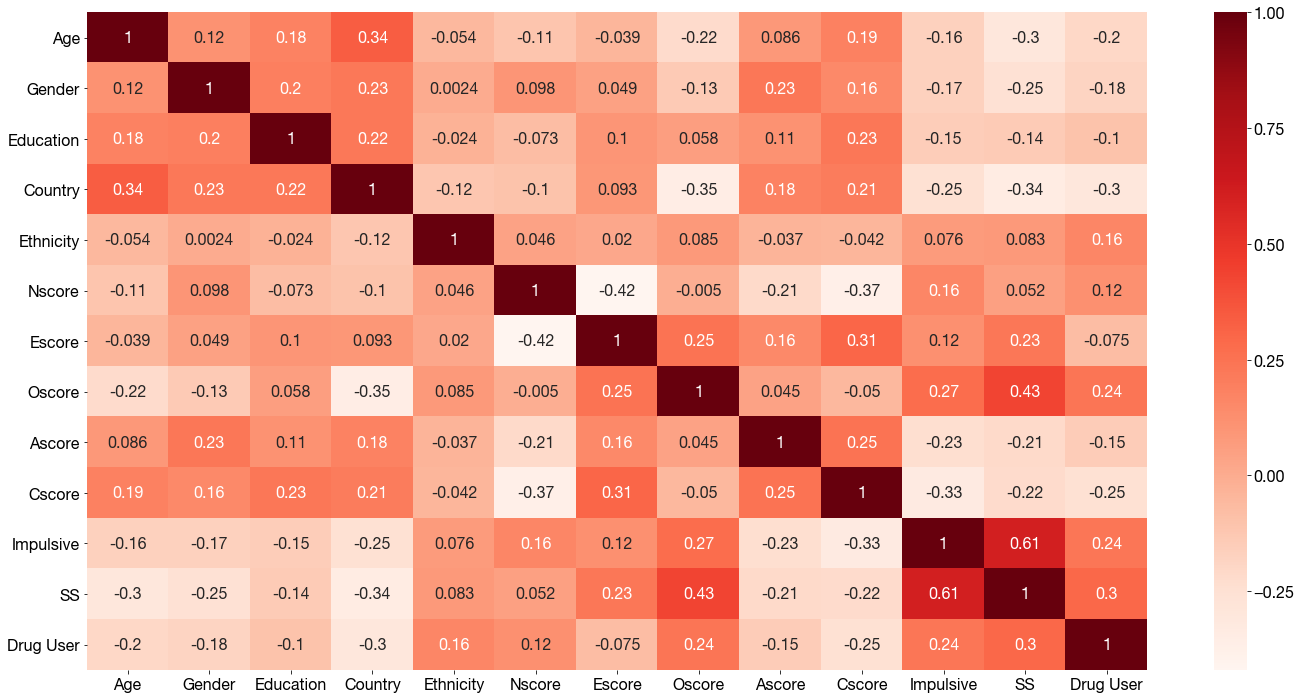

In [4]:
# Examine input variables
matplotlib.rc('font', family='Helvetica Neue', size=16)
fig  = plt.gcf()
fig.set_size_inches(20, 10)
corr = train_data.drop(columns=['Amphet',
                                'Amyl',
                                'Benzos',
                                'Cannabis',
                                'Coke',
                                'Crack',
                                'Ecstacy',
                                'Heroin',
                                'Ketamine',
                                'LSD',
                                'Meth',
                                'Mushrooms',
                                'VSA']).corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.tight_layout()
plt.savefig('figures/heatmap.png', dpi=300)

# Correlation with output variable
corr_target = abs(corr['Drug User'])

# Select relevant variables
variables   = corr_target[corr_target > corr_target.loc['Age':'SS'].median()]
variables   = variables.loc['Age':'SS'].index.values
var_indices = [train_data.columns.get_loc(variable) for variable in variables]
print('Relevant variables (corr > %.3f):'%corr_target.loc['Age':'SS'].median(), variables)

In [5]:
drop_cols = ['Amphet', 'Amyl', 'Benzos', 'Cannabis',
             'Coke', 'Crack', 'Ecstacy', 'Heroin',
             'Ketamine', 'LSD', 'Meth', 'Mushrooms',
             'VSA', 'Drug User']
x_train = train_data.drop(columns=drop_cols)
x_test  = test_data.drop (columns=drop_cols)
y_train = train_data['Drug User']
y_test  = test_data ['Drug User']

# Standardize training and testing data
scaler         = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.fit_transform(x_test)

In [6]:
# Build a decision tree classifier to classify people as drug users or non-users
classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
classifier.fit(x_train_scaled[:, var_indices], y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [7]:
# Show the structure of the decision tree classifier
print(classifier.tree_.__getstate__()['nodes'])
len(classifier.tree_.__getstate__()['nodes'])

[(  1,  88,  1,  0.37104077, 0.61578458, 1319, 1.319e+03)
 (  2,  33,  1, -1.03708935, 0.21804385,  603, 6.030e+02)
 (  3,   4,  3, -0.71024391, 0.09916557,  389, 3.890e+02)
 ( -1,  -1, -2, -2.        , 0.        ,  124, 1.240e+02)
 (  5,   6,  4, -0.48617859, 0.1350362 ,  265, 2.650e+02)
 ( -1,  -1, -2, -2.        , 0.        ,   66, 6.600e+01)
 (  7,  16,  0, -0.6268507 , 0.16932446,  199, 1.990e+02)
 (  8,   9,  2,  1.30229104, 0.07360348,  112, 1.120e+02)
 ( -1,  -1, -2, -2.        , 0.        ,   89, 8.900e+01)
 ( 10,  15,  2,  1.5078187 , 0.25801867,   23, 2.300e+01)
 ( 11,  12,  4,  0.75859267, 0.54356444,    8, 8.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    6, 6.000e+00)
 ( 13,  14,  3,  0.49862912, 1.        ,    2, 2.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,    1, 1.000e+00)
 ( -1,  -1, -2, -2.        , 0.        ,   15, 1.500e+01)
 ( 17,  30,  3,  1.46841699, 0.2690553 ,   87, 8.700e+01)
 ( 18,  25,  5

475

In [8]:
# The mean accuracy and the 95% confidence interval of 10-fold cross validation
scores = cross_val_score(classifier, x_train_scaled[:, var_indices], y_train,
                         cv=10, scoring='accuracy')
print('Accuracy: %0.3f (+/- %0.3f)'%(scores.mean(), scores.std() * 2))

# The mean F1 score and the 95% confidence interval of 10-fold cross validation
scores = cross_val_score(classifier, x_train_scaled[:, var_indices], y_train,
                         cv=10, scoring='f1')
print('F1 score: %0.3f (+/- %0.3f)'%(scores.mean(), scores.std() * 2))

Accuracy: 0.790 (+/- 0.082)
F1 score: 0.874 (+/- 0.054)


In [9]:
# Feature importances (aka Gini importance)
count = 0
print('Gini importance:')
for (variable, feature_importance) in sorted(zip(variables,
    classifier.feature_importances_), key=lambda x: x[1], reverse=True):
    count += 1
    print('(%d)' % count, '%0.3f,'%feature_importance, variable)

Gini importance:
(1) 0.243, Cscore
(2) 0.203, Oscore
(3) 0.173, SS
(4) 0.135, Country
(5) 0.131, Age
(6) 0.115, Impulsive


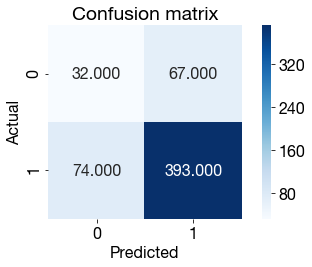

In [10]:
# Predict the class labels for the test set using the decision tree classifier
y_pred = classifier.predict(x_test_scaled[:, var_indices])

# Plot the corresponding confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='.3f', square=True, cmap=plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()
plt.savefig('figures/conf_matrix_dt.png', dpi=300)

In [11]:
# Compute evaluation metrics for the decision tree classifier
accuracy  = metrics.accuracy_score(y_test, y_pred)
error     = 1 - metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average=None)
recall    = metrics.recall_score(y_test, y_pred, average=None)
f1_score  = metrics.f1_score(y_test, y_pred, average=None)
print('Accuracy: ', '%0.3f'%accuracy)
print('Error:    ', '%0.3f'%error)
print('Precision:', '[%0.3f'%precision[0], '%0.3f]'%precision[1])
print('Recall:   ', '[%0.3f'%recall[0],    '%0.3f]'%recall[1])
print('F1 score: ', '[%0.3f'%f1_score[0],  '%0.3f]'%f1_score[1])

Accuracy:  0.751
Error:     0.249
Precision: [0.302 0.854]
Recall:    [0.323 0.842]
F1 score:  [0.312 0.848]


In [12]:
# Build a k-nearest neighbors classifier to classify people as drug users or non-users
classifier = KNeighborsClassifier(n_neighbors=3) 
classifier.fit(x_train_scaled[:, var_indices], y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [13]:
# The mean accuracy and the 95% confidence interval of 10-fold cross validation
scores = cross_val_score(classifier, x_train_scaled[:, var_indices], y_train,
                         cv=10, scoring='accuracy')
print('Accuracy: %0.3f (+/- %0.3f)'%(scores.mean(), scores.std() * 2))

# The mean F1 score and the 95% confidence interval of 10-fold cross validation
scores = cross_val_score(classifier, x_train_scaled[:, var_indices], y_train,
                         cv=10, scoring='f1')
print('F1 score: %0.3f (+/- %0.3f)'%(scores.mean(), scores.std() * 2))

Accuracy: 0.809 (+/- 0.060)
F1 score: 0.888 (+/- 0.037)


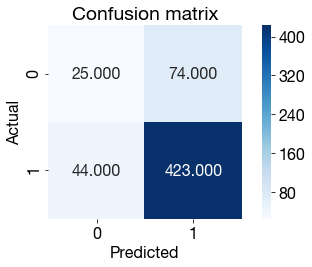

In [14]:
# Predict the class labels for the test set using the k-nearest neighbors classifier
y_pred = classifier.predict(x_test_scaled[:, var_indices])

# Plot the corresponding confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='.3f', square=True, cmap=plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()
plt.savefig('figures/conf_matrix_knn.png', dpi=300)

In [15]:
# Compute evaluation metrics for the k-nearest neighbors classifier
accuracy  = metrics.accuracy_score(y_test, y_pred)
error     = 1 - metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average=None)
recall    = metrics.recall_score(y_test, y_pred, average=None)
f1_score  = metrics.f1_score(y_test, y_pred, average=None)
print('Accuracy: ', '%0.3f'%accuracy)
print('Error:    ', '%0.3f'%error)
print('Precision:', '[%0.3f'%precision[0], '%0.3f]'%precision[1])
print('Recall:   ', '[%0.3f'%recall[0],    '%0.3f]'%recall[1])
print('F1 score: ', '[%0.3f'%f1_score[0],  '%0.3f]'%f1_score[1])

Accuracy:  0.792
Error:     0.208
Precision: [0.362 0.851]
Recall:    [0.253 0.906]
F1 score:  [0.298 0.878]


In [16]:
def gender_map(x):
    if math.isclose(x, 0.48246):
        return 'Female'
    else:
        return 'Male'

In [17]:
def country_map(x):
    countries = [(-0.09765, 'Australia'), (0.24923,'Canada'), 
               (-0.46841,'New Zealand'), (0.21128,'Republic of Ireland'), 
               (0.96082,'UK'), (-0.57009,'USA'), (-0.28519,'Other')]
    for (value, country) in countries:
        if math.isclose(x, value):
            return country;
    return None

In [18]:
# Function to determine illegal drug usage per person
def is_drug_user(row):
    row = row['Amphet':]
    num_zeros = (row == 0).astype(bool).sum()
    if num_zeros == row.size:
        return False
    return True

In [19]:
train_data = pd.read_csv("train_data.csv", delimiter='\t', index_col=0)
test_data = pd.read_csv("test_data.csv", delimiter='\t', index_col=0)

In [20]:
def create_plot(ax, data, color='#99004f'):
    usage = data.apply(pd.Series.value_counts, axis=0)
    drug = usage.iloc[:,0].name
    usages = usage.sort_index().iloc[:,0].values
    width = 0.05
    xpos = np.arange(len(usage.index),dtype='float64')
    xpos *= 0.10
    ax.bar(xpos, usages, width=width, color=color)
    rects = ax.patches
    for rect, usage in zip(rects,usages):
        x = rect.get_x() + rect.get_width()/2
        y = rect.get_height() + 0.5
        ax.text(x, y, usage, ha='center',va='bottom', fontsize=5)
    
    usage_texts = ['Never Used','Decade Ago','Last Decade', 
                   'Last Year', 'Last Month', 
                   'Last Week', 'Last Day']
    ax.set_ylim(bottom=0, top=1800)
    ax.set_xticks(xpos)
    ax.set_xticklabels(usage_texts)
    ax.tick_params(axis='y', labelsize=4)
    ax.tick_params(axis ='x', labelrotation=15, labelsize=4, width=0.7)
    ax.text(0.5, 0.9, drug, horizontalalignment='center', 
            transform=ax.transAxes, fontsize=9)

In [21]:
def create_usage_subplots(data):
    
    colors = ['#99004f', '#007acc', '#009900', '#e67300',
              '#cc0000','#0000b3', '#7a00cc', '#e6e600',
              '#2eb8b8']
    
    data = data.rename(columns={'Amphet':'Amphetamine', 'Amyl':'Amyl Nitrite',
            'Benzos':'Benzodiazepine','Caff':'Caffeine','Coke':'Cocaine',
            'Meth':'Methamphetamine'})
    
    
    drug_data = data.loc[:,'Alcohol':].apply(lambda series: series.astype(bool).sum(),axis=0)
    drug_data = drug_data.sort_values(ascending=False)
    print(drug_data)
    drugs = drug_data.index.values

    nrows = 5
    ncols= 4
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, sharey=True, figsize=(10,8))
    plt.subplots_adjust(wspace=0.02, hspace= 0.3, top = 0.95)
    color_idx = 0
    i = 0
    for row in range(nrows):
        for col in range(ncols):
            if col != 0:
                axs[row, col].tick_params(axis='y', width=0)
            if i >= len(drugs):
                axs[row, col].set_visible(False)
            else:
                create_plot(axs[row, col], data[[drugs[i]]], colors[color_idx])
            i += 1
            color_idx = (color_idx+1)%len(colors)
    fig.savefig('figures/drugs.png', dpi=300)
    plt.show()
    plt.clf()

In [22]:
plot_data = pd.read_csv('drug_consumption.csv')
mpl.rcParams['axes.linewidth'] = 0.5

In [23]:
# label encode categorical variables
for column in plot_data.loc[:,'Alcohol':'VSA']:
    # get label encoding for column
    plot_data[column] = plot_data[column].astype('category').cat.codes
    # convert column to numeric type
    plot_data[column] = plot_data[column].astype('int32')

In [24]:
# drop fake drug
del plot_data['Semer'] 
# drop ID variable
del plot_data['ID']
# drop chocolate
del plot_data['Choc']

Caffeine           1858
Alcohol            1851
Cannabis           1472
Nicotine           1457
Amphetamine         909
Mushrooms           903
Benzodiazepine      885
Ecstacy             864
Cocaine             847
LSD                 816
Legalh              791
Amyl Nitrite        580
Methamphetamine     456
VSA                 430
Ketamine            395
Heroin              280
Crack               258
dtype: int64


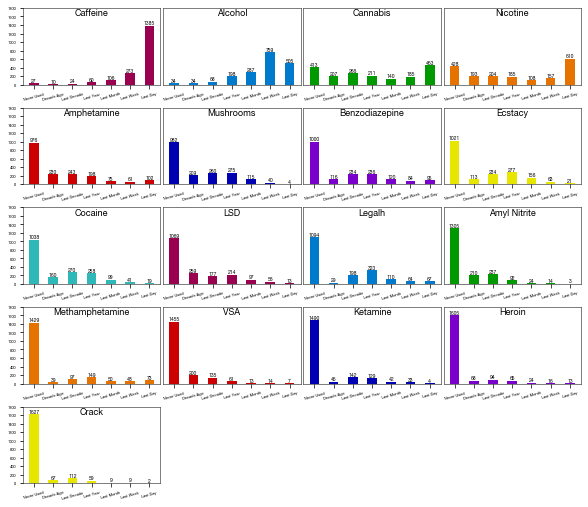

<Figure size 432x288 with 0 Axes>

In [25]:
create_usage_subplots(plot_data)

In [26]:
min_score = plot_data.loc[:,'Nscore':'Cscore'].min().values.min()
plot_data.loc[:,'Nscore':'Cscore'] += abs(min_score)

In [27]:
# Create drug user columns for illegal drug usage
plot_data['Drug User'] = plot_data.drop(['Alcohol', 'Nicotine','Caff', 'Legalh'], axis=1).apply(is_drug_user, axis=1)
plot_data['Gender']= plot_data['Gender'].apply(gender_map)
plot_data['Country']=plot_data['Country'].apply(country_map)

In [28]:
# Create dataset for drug users
users = plot_data.loc[plot_data['Drug User'] == True]
# Create dataset for non-drug users
nonusers = plot_data.loc[plot_data['Drug User'] == False]

In [29]:
# Get data for male drug users
male_users = users.loc[(users['Gender'] == 'Male')]
male_users = male_users.reset_index(drop=True)

In [30]:
# Get data for female drug users
female_users = users.loc[(users['Gender'] == 'Female')]
female_users = female_users.reset_index(drop=True)

In [31]:
def create_personality_plot(users, nonusers):
    traits = ['Neuroticism', 'Extraversion', 'Openness', 
              'Agreeablenes', 'Conscientiousnes']
    users_scores = users.loc[:,'Nscore':'Cscore'].mean().values
    nonusers_scores = nonusers.loc[:,'Nscore':'Cscore'].mean().values
    width = 0.3
    users_xpos = np.arange(len(users_scores))
    nonusers_xpos = [x + width for x in users_xpos]
    
    plt.bar(users_xpos, users_scores, width=width, color=['#007acc'], label='Users')
    plt.bar(nonusers_xpos, nonusers_scores, width=width, color=['#009900'], label='Non-users')
    ax = plt.gca()
    rects = ax.patches
    for rect, score in zip(rects[:5],users_scores):
        x = rect.get_x() + rect.get_width()/2
        y = rect.get_height() + 0.05
        ax.text(x, y, np.round(score, 2), ha='center',va='bottom', fontsize=10)
    for rect, score in zip(rects[5:],nonusers_scores):
        x = rect.get_x() + rect.get_width()/2
        y = rect.get_height() + 0.05
        ax.text(x, y, np.round(score, 2), ha='center',va='bottom', fontsize=10)
    plt.title('Personality Trait Scores for Illegal Drug Users')
    plt.xlabel('Personality Traits')
    plt.ylabel('Mean Scores')
    plt.xticks(users_xpos+width/2, traits)
    plt.legend(loc='upper left',shadow=True)
    fig = plt.gcf()
    fig.set_size_inches(10,9)
    plt.savefig('figures/traits.png', dpi=300)
    plt.show()
    plt.clf()

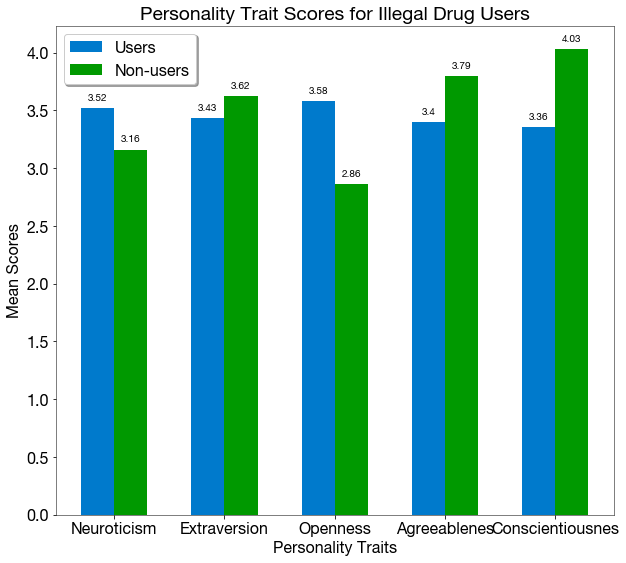

<Figure size 432x288 with 0 Axes>

In [32]:
create_personality_plot(users, nonusers)

In [33]:
illegal_drugs = plot_data.drop(['Alcohol', 'Nicotine','Caff', 'Legalh'], axis=1).loc[:, 'Amphet':'VSA']
plot_data['Last Used'] = illegal_drugs.apply(lambda series: series.max(), axis=1)
males = plot_data.loc[(plot_data['Gender'] == 'Male')]
males = males.reset_index(drop=True)
males.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 31 columns):
Age          943 non-null float64
Gender       943 non-null object
Education    943 non-null float64
Country      943 non-null object
Ethnicity    943 non-null float64
Nscore       943 non-null float64
Escore       943 non-null float64
Oscore       943 non-null float64
Ascore       943 non-null float64
Cscore       943 non-null float64
Impulsive    943 non-null float64
SS           943 non-null float64
Alcohol      943 non-null int32
Amphet       943 non-null int32
Amyl         943 non-null int32
Benzos       943 non-null int32
Caff         943 non-null int32
Cannabis     943 non-null int32
Coke         943 non-null int32
Crack        943 non-null int32
Ecstacy      943 non-null int32
Heroin       943 non-null int32
Ketamine     943 non-null int32
Legalh       943 non-null int32
LSD          943 non-null int32
Meth         943 non-null int32
Mushrooms    943 non-null int32
Nicotine 

In [34]:
females = plot_data.loc[(plot_data['Gender'] == 'Female')]
females = females.reset_index(drop=True)

In [35]:
male_freq = males['Last Used'].value_counts().sort_index().values
male_freq

array([ 84,  60,  80,  84,  86, 146, 403])

In [36]:
female_freq = females['Last Used'].value_counts().sort_index().values
female_freq

array([216, 110, 161, 105,  56,  78, 216])

In [37]:
def create_gender_freq_plot(ax, male_freq, female_freq):
    usage_texts = ['Never Used','Decade Ago','Last Decade', 
                   'Last Year', 'Last Month', 
                   'Last Week', 'Last Day']
    width = 0.3
    males_xpos = np.arange(len(male_freq))
    females_xpos = [x + width for x in males_xpos]
    ax.bar(males_xpos, male_freq, width=width, color=['#2eb8b8'], label='Male')
    ax.bar(females_xpos, female_freq, width=width, color=['#99004f'], label='Female')
    rects = ax.patches
    for rect, freq in zip(rects[:7], male_freq):
        x = rect.get_x() + rect.get_width()/2
        y = rect.get_height() + 0.05
        ax.text(x, y, freq, ha='center',va='bottom', fontsize=10)
    for rect, freq in zip(rects[7:], female_freq):
        x = rect.get_x() + rect.get_width()/2
        y = rect.get_height() + 0.05
        ax.text(x, y, freq, ha='center',va='bottom', fontsize=10)
    ax.tick_params(axis ='x', labelrotation=15)
    ax.legend(loc='upper left',shadow=True)
    ax.set_xticks(males_xpos+width/2)
    ax.set_xticklabels(usage_texts)
    ax.set_ylabel('Users')
    ax.set_title('Frequency of Illegal Drug Usage by Gender')

In [38]:
def create_gender_plot(ax, male_users, female_users):
    xpos = np.arange(2)
    bars = [len(male_users.index), len(female_users.index)]
    
    ax.bar(xpos, bars, width=0.3, color=['#2eb8b8','#99004f'], align='center')
    
    rects = ax.patches
    for rect, score in zip(rects,bars):
        x = rect.get_x() + rect.get_width()/2
        y = rect.get_height() + 0.05
        ax.text(x, y, np.round(score, 2), ha='center',va='bottom', fontsize=10)
    
    ax.set_xticks(xpos)
    ax.set_xticklabels(['Male', 'Female'])
    ax.set_title('Illegal Drug Usage by Gender')
    ax.set_ylabel('Users')

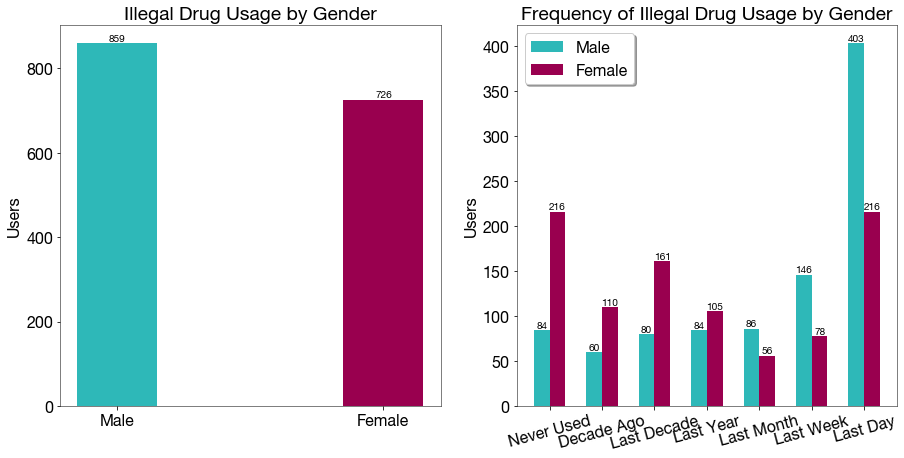

<Figure size 432x288 with 0 Axes>

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15,7))
create_gender_plot(ax1, male_users, female_users)
create_gender_freq_plot(ax2, male_freq, female_freq)
fig.savefig('figures/gender_freq.png', dpi=300)
plt.show()
plt.clf()

In [40]:
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [41]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 32 columns):
ID           1319 non-null int64
Age          1319 non-null float64
Gender       1319 non-null float64
Education    1319 non-null float64
Country      1319 non-null float64
Ethnicity    1319 non-null float64
Nscore       1319 non-null float64
Escore       1319 non-null float64
Oscore       1319 non-null float64
Ascore       1319 non-null float64
Cscore       1319 non-null float64
Impulsive    1319 non-null float64
SS           1319 non-null float64
Alcohol      1319 non-null object
Amphet       1319 non-null object
Amyl         1319 non-null object
Benzos       1319 non-null object
Caff         1319 non-null object
Cannabis     1319 non-null object
Choc         1319 non-null object
Coke         1319 non-null object
Crack        1319 non-null object
Ecstacy      1319 non-null object
Heroin       1319 non-null object
Ketamine     1319 non-null object
Legalh       1319 non-null objec

In [42]:
# Drop ID, Chocolate, the fake drug Semer, and legal substances
train_data.drop(['ID', 'Choc', 'Semer', 'Alcohol', 'Nicotine', 'Caff','Legalh'], axis=1, inplace=True)
test_data.drop(['ID', 'Choc', 'Semer',  'Alcohol', 'Nicotine', 'Caff','Legalh'], axis=1, inplace=True)

In [43]:
for column in train_data.loc[:,'Amphet':]:
    # get label encoding for column
    train_data[column] = train_data[column].astype('category').cat.codes.astype('int32')
    test_data[column] = test_data[column].astype('category').cat.codes.astype('int32')

In [44]:
# Combine illegal drug usage into a single boolean variable
train_data['Drug User'] = train_data.apply(is_drug_user, axis=1)
test_data['Drug User'] = test_data.apply(is_drug_user, axis=1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 26 columns):
Age          1319 non-null float64
Gender       1319 non-null float64
Education    1319 non-null float64
Country      1319 non-null float64
Ethnicity    1319 non-null float64
Nscore       1319 non-null float64
Escore       1319 non-null float64
Oscore       1319 non-null float64
Ascore       1319 non-null float64
Cscore       1319 non-null float64
Impulsive    1319 non-null float64
SS           1319 non-null float64
Amphet       1319 non-null int32
Amyl         1319 non-null int32
Benzos       1319 non-null int32
Cannabis     1319 non-null int32
Coke         1319 non-null int32
Crack        1319 non-null int32
Ecstacy      1319 non-null int32
Heroin       1319 non-null int32
Ketamine     1319 non-null int32
LSD          1319 non-null int32
Meth         1319 non-null int32
Mushrooms    1319 non-null int32
VSA          1319 non-null int32
Drug User    1319 non-null bool
dtypes: bool

In [45]:
X_train = train_data.loc[:,'Age':'SS']
y_train = train_data['Drug User']

In [46]:
# Feature selection
sel = SelectFromModel(RandomForestClassifier(random_state=0), threshold=0.05)
sel.fit(X_train, y_train)
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat.values)

['Age' 'Education' 'Country' 'Nscore' 'Escore' 'Oscore' 'Ascore' 'Cscore'
 'Impulsive' 'SS']


/Users/mashy426/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [47]:
# Grid search for random forest (30,240 base estimators)
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 100, num = 20)] + [None]
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 20)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
criterion=['entropy','gini']
bootstrap = [True, False]
grid = {'max_features': max_features,
        'max_depth': max_depth,
        'n_estimators': n_estimators,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'criterion': criterion,
        'bootstrap': bootstrap}

In [48]:
# Base classifier used for grid search
forest = RandomForestClassifier(random_state=0)
# Use 100 iterations and 10-fold cross-validation, using 4 cores
forest_grid_search = RandomizedSearchCV(estimator = forest, param_distributions = grid, 
                               n_iter = 100, cv = 10, verbose=2, random_state=0, n_jobs = 4)

In [49]:
# Use features selected for training and testing
X_train = train_data[selected_feat.values]
y_train = train_data['Drug User']

X_test = test_data[selected_feat.values]
y_test = test_data['Drug User']

In [50]:
# Fit features selected to grid search (slow process)
forest_grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   17.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  6.1min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=Non

In [51]:
# Store the dictionary of best parameters
params = forest_grid_search.best_params_
params

{'n_estimators': 621,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 70,
 'criterion': 'entropy',
 'bootstrap': True}

In [52]:
search_data = pd.DataFrame(forest_grid_search.cv_results_)
search_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 25 columns):
mean_fit_time              100 non-null float64
std_fit_time               100 non-null float64
mean_score_time            100 non-null float64
std_score_time             100 non-null float64
param_n_estimators         100 non-null object
param_min_samples_split    100 non-null object
param_min_samples_leaf     100 non-null object
param_max_features         100 non-null object
param_max_depth            95 non-null object
param_criterion            100 non-null object
param_bootstrap            100 non-null object
params                     100 non-null object
split0_test_score          100 non-null float64
split1_test_score          100 non-null float64
split2_test_score          100 non-null float64
split3_test_score          100 non-null float64
split4_test_score          100 non-null float64
split5_test_score          100 non-null float64
split6_test_score          100 non-null f

In [53]:
# Convert estimators column to integer type
search_data['param_n_estimators'] = search_data['param_n_estimators'].astype('int32')

In [54]:
estimators = search_data[['param_n_estimators', 'mean_fit_time', 'mean_test_score']].sort_values(
    by=['param_n_estimators'])
estimators.head

<bound method NDFrame.head of     param_n_estimators  mean_fit_time  mean_test_score
97                 100       0.233022         0.842305
46                 100       0.253645         0.834723
39                 100       0.174821         0.844579
92                 100       0.339023         0.836240
68                 100       0.184744         0.846096
47                 147       0.346886         0.840030
81                 147       0.438675         0.837756
27                 147       0.299779         0.846854
66                 147       0.294634         0.846854
91                 147       0.420394         0.843063
48                 147       0.411381         0.838514
24                 147       0.569630         0.840030
89                 194       0.442677         0.842305
86                 194       0.349186         0.846096
98                 194       0.411359         0.843821
58                 194       0.340843         0.846854
29                 242       0.7846

In [55]:
max_depths = search_data[['param_max_depth', 'mean_test_score']]
# Remove rows with max depth of None for plotting
max_depths = max_depths[max_depths['param_max_depth'].notnull()]
# Sort values by max depth
max_depths.sort_values(by=['param_max_depth'], inplace=True)
max_depths.reset_index(drop=True, inplace=True)
max_depths.head

<bound method NDFrame.head of    param_max_depth  mean_test_score
0                5         0.845337
1                5         0.846096
2                5         0.847612
3                5         0.846096
4                5         0.846854
5               10         0.842305
6               10         0.840788
7               15         0.846096
8               15         0.833965
9               15         0.840030
10              15         0.843821
11              15         0.843821
12              20         0.846854
13              20         0.840030
14              20         0.833965
15              20         0.834723
16              25         0.840788
17              25         0.848370
18              25         0.840030
19              30         0.840030
20              30         0.835481
21              30         0.840788
22              30         0.844579
23              30         0.841547
24              30         0.841547
25              30         0.83624

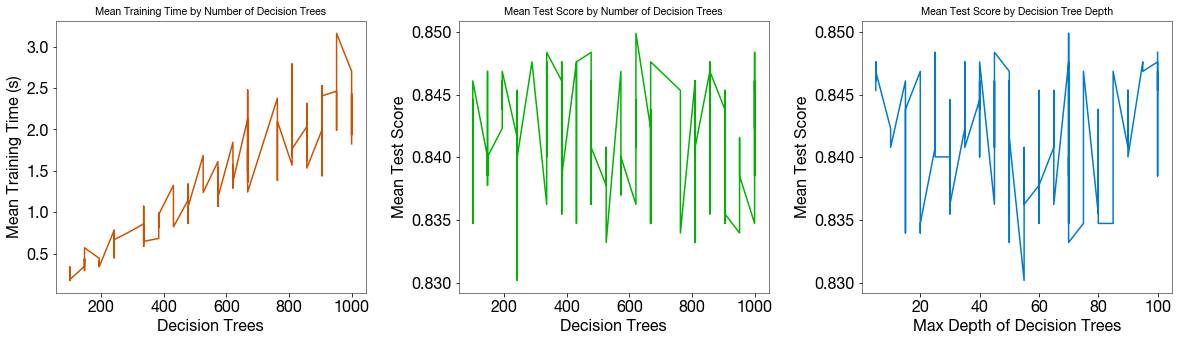

In [56]:
# Plot visuals for grid search
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=False)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(20, 5)

ax1.plot(estimators['param_n_estimators'], estimators['mean_fit_time'], color='#cc5200')
ax1.set_xlabel('Decision Trees')
ax1.set_ylabel('Mean Training Time (s)')
ax1.set_title('Mean Training Time by Number of Decision Trees', fontdict={'fontsize':10.5})

ax2.plot(estimators['param_n_estimators'], estimators['mean_test_score'], color='#00b300')
ax2.set_xlabel('Decision Trees')
ax2.set_ylabel('Mean Test Score')
ax2.set_title('Mean Test Score by Number of Decision Trees',fontdict={'fontsize':10.5})

ax3.plot(max_depths['param_max_depth'], max_depths['mean_test_score'], color='#007acc')
ax3.set_xlabel('Max Depth of Decision Trees')
ax3.set_ylabel('Mean Test Score')
ax3.set_title('Mean Test Score by Decision Tree Depth',fontdict={'fontsize':10.5})
plt.savefig('gridsearch.png', dpi=300)

In [57]:
# Get mean cross-validation score using best paramaters from grid search
forest = RandomForestClassifier(n_estimators=params['n_estimators'], min_samples_split=params['min_samples_split'], 
                                min_samples_leaf=params['min_samples_leaf'], max_features=params['max_features'], 
                                max_depth=params['max_depth'], bootstrap=params['bootstrap'], random_state=0)

In [58]:
scores = cross_val_score(forest, X_train, y_train, scoring='accuracy', cv=10)

In [59]:
print("Mean Accuracy: %f"%(scores.mean()))

Mean Accuracy: 0.844579


In [60]:
scores = cross_val_score(forest, X_train, y_train, scoring='f1', cv=10)

In [61]:
print("Mean F1 Score: %f"%(scores.mean()))

Mean F1 Score: 0.913897


In [62]:
forest = RandomForestClassifier(n_estimators=params['n_estimators'], min_samples_split=params['min_samples_split'], 
                                min_samples_leaf=params['min_samples_leaf'], max_features=params['max_features'], 
                                max_depth=params['max_depth'], bootstrap=params['bootstrap'], random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=70, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=621,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Text(0.5, 1.0, 'Feature Importances for Model')

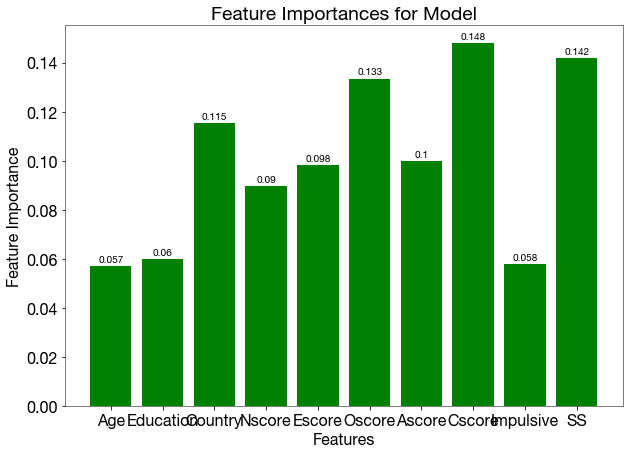

In [63]:
plt.bar(np.arange(len(X_train.columns)), forest.feature_importances_, tick_label=X_train.columns.values, color='g')
fig = plt.gcf()
ax = plt.gca()
rects = ax.patches
for rect, importance in zip(rects, forest.feature_importances_):
    x = rect.get_x() + rect.get_width()/2
    y = rect.get_height() + 0.001
    ax.text(x, y, np.round(importance, 3), ha='center',va='bottom', fontsize=10)
fig.set_size_inches(10,7)
plt.ylabel('Feature Importance')
plt.xlabel('Features')
plt.title('Feature Importances for Model')

In [64]:
# Calculate metrics
y_pred = forest.predict(X_test)
accuracy  = metrics.accuracy_score(y_test, y_pred)
error     = 1 - metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average=None)
recall    = metrics.recall_score(y_test, y_pred, average=None)
f1_score  = metrics.f1_score(y_test, y_pred, average=None)
print('Accuracy:  ', '%0.3f'%(accuracy))
print('Error:     ', '%0.3f'%(error))
print('Precision: ', precision)
print('Recall:    ', recall)
print('F1 score:  ', f1_score)

Accuracy:   0.827
Error:      0.173
Precision:  [0.51428571 0.84745763]
Recall:     [0.18181818 0.96359743]
F1 score:   [0.26865672 0.90180361]


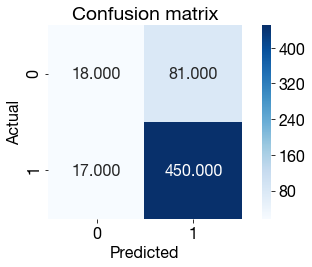

In [65]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='.3f', square=True, cmap=plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()
plt.savefig('figures/random_forest_matrix.png', dpi=300)

In [66]:
data = pd.read_csv("drug_consumption.csv")
data.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,...,Ecstacy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [67]:
#Source: https://drugs.laws.com/list-of-illegal-drugs
#Grouping Illegal and Non-Illegal drugs
illegal_drugs = ['Amphet','Coke','Crack','Ecstacy','Heroin','LSD','Mushrooms']
Non_illegal =[i for i in data.columns[13:] if i not in illegal_drugs]

In [68]:
#Stripping all 'CL' from all the drug columns
for drug in data.columns[13:]:
        data[drug] = data[drug].map(lambda x: int(str(x).lstrip('CL')))

In [69]:
#Start with Clusters
#Cluster1: Using all the columns
#Cluster1 with Hierarchial clustering single linkage

In [70]:
variables = data.columns
var_indices = [data.columns.get_loc(variable) for variable in variables]

In [71]:
print(var_indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [72]:
#Standardizing the data
x = data.iloc[:,var_indices]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [73]:
clustering = linkage(x_scaled,method="single",metric="euclidean")
clusters = fcluster(clustering, 2, criterion = 'maxclust')
clusters = clusters - 1
print(clusters)

[1 1 1 ... 1 1 1]


In [74]:
data['clusters'] = clusters

In [75]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.5079507583610615


In [76]:
#Cluster1 with Hierarchial clustering Complete Linkage

In [77]:
clustering = linkage(x_scaled,method="complete",metric="euclidean")
clusters = fcluster(clustering, 2, criterion = 'maxclust')
clusters = clusters - 1
print(clusters)

[1 1 1 ... 1 1 1]


In [78]:
data['clusters'] = clusters

In [79]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.6629990546490399


[Text(0, 0.5, 'Crack'),
 Text(0.5, 0, 'Age'),
 Text(0.5, 1.0, 'Drug Consumption')]

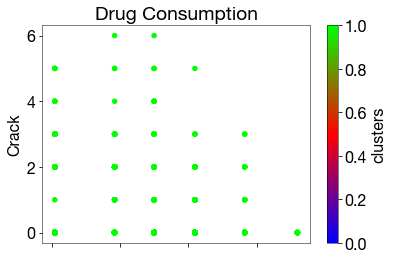

In [80]:
ax = data.plot(kind = 'scatter', x = 'Age', y = 'Crack', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Age', ylabel = 'Crack')

[Text(0, 0.5, 'Coke'),
 Text(0.5, 0, 'Ascore'),
 Text(0.5, 1.0, 'Drug Consumption')]

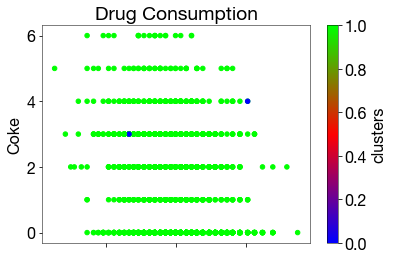

In [81]:
ax = data.plot(kind = 'scatter', x = 'Ascore', y = 'Coke', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Ascore', ylabel = 'Coke')

[Text(0, 0.5, 'Nscore'),
 Text(0.5, 0, 'Ascore'),
 Text(0.5, 1.0, 'Drug Consumption')]

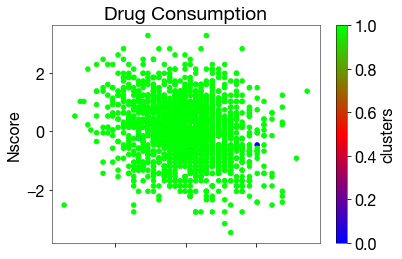

In [82]:
ax = data.plot(kind = 'scatter', x = 'Ascore', y = 'Nscore', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Ascore', ylabel = 'Nscore')

[Text(0, 0.5, 'Coke'),
 Text(0.5, 0, 'Crack'),
 Text(0.5, 1.0, 'Drug Consumption')]

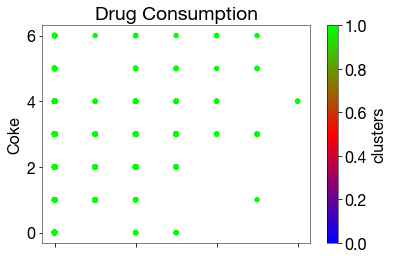

In [83]:
ax = data.plot(kind = 'scatter', x = 'Crack', y = 'Coke', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Crack',ylabel = 'Coke')

[Text(0, 0.5, 'Coke'),
 Text(0.5, 0, 'Nicotine'),
 Text(0.5, 1.0, 'Drug Consumption')]

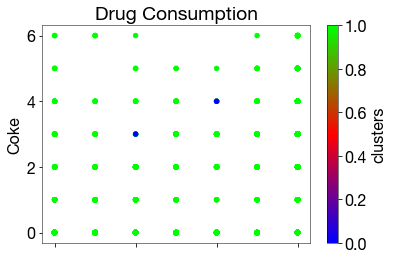

In [84]:
ax = data.plot(kind = 'scatter', x = 'Nicotine', y = 'Coke', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Nicotine', ylabel = 'Coke')

In [85]:
#Cluster1 with K-Means

In [86]:
clustering = KMeans(n_clusters = 2, init = 'random', n_init = 1, random_state = 0).fit(x_scaled)
clusters = clustering.labels_
print(clusters)
data['clusters'] = clusters

[0 1 0 ... 1 1 1]


In [87]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.18301116784616245


In [88]:
#Cluster1 with DBSCAN

In [89]:
clustering = DBSCAN(eps = 2, min_samples = 4, metric = "euclidean").fit(x_scaled) 
clusters = clustering.labels_
data['clusters'] = clusters

In [90]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

-0.1898724108691829


In [91]:
# print(metrics.adjusted_rand_score(data['clusters']))
# We cannot use rand index cause we do not have anything to compare the clusters against

In [92]:
#Cluster2: Using only Non-illegal drugs

In [93]:
variables = Non_illegal
var_indices = [data.columns.get_loc(variable) for variable in variables]

In [94]:
#Standardizing the data
x = data.iloc[:,var_indices]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [95]:
clustering = linkage(x_scaled,method="single",metric="euclidean")
clusters = fcluster(clustering, 2, criterion = 'maxclust')
clusters = clusters - 1
print(clusters)

[0 0 0 ... 0 0 0]


In [96]:
data['clusters'] = clusters

In [97]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.8233760416358061


[Text(0, 0.5, 'Meth'),
 Text(0.5, 0, 'Nicotine'),
 Text(0.5, 1.0, 'Drug Consumption')]

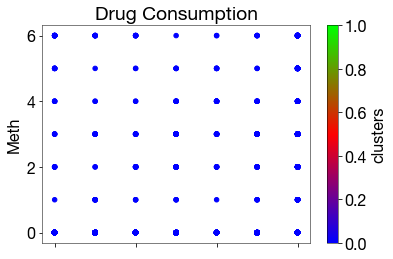

In [98]:
ax = data.plot(kind = 'scatter', x = 'Nicotine', y = 'Meth', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Nicotine', ylabel = 'Meth')

[Text(0, 0.5, 'Alcohol'),
 Text(0.5, 0, 'Nicotine'),
 Text(0.5, 1.0, 'Drug Consumption')]

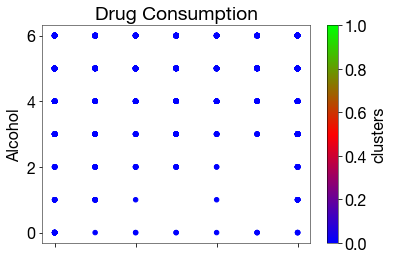

In [99]:
ax = data.plot(kind = 'scatter', x = 'Nicotine', y = 'Alcohol', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Nicotine', ylabel = 'Alcohol')

[Text(0, 0.5, 'Meth'),
 Text(0.5, 0, 'Amyl'),
 Text(0.5, 1.0, 'Drug Consumption')]

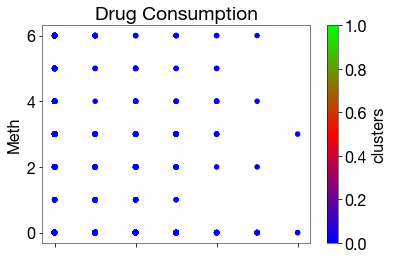

In [100]:
ax = data.plot(kind = 'scatter', x = 'Amyl', y = 'Meth', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Amyl', ylabel = 'Meth')

In [101]:
#Cluster2 with complete Linkage

In [102]:
clustering = linkage(x_scaled,method="complete",metric="euclidean")
clusters = fcluster(clustering, 2, criterion = 'maxclust')
clusters = clusters - 1
print(clusters)

[1 1 1 ... 1 1 1]


In [103]:
data['clusters'] = clusters

In [104]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.7931811284335685


In [105]:
#Cluster2 with K-Means

In [106]:
clustering = KMeans(n_clusters = 2, init = 'random', n_init = 1, random_state = 0).fit(x_scaled)
clusters = clustering.labels_
print(clusters)
data['clusters'] = clusters

[0 1 0 ... 1 1 1]


In [107]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.22503062682481748


In [108]:
#Cluster2 with DBSCAN

In [109]:
clustering = DBSCAN(eps = 2, min_samples = 3, metric = "euclidean").fit(x_scaled)
clusters = clustering.labels_
data['clusters'] = clusters

In [110]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.09401786652049447


In [111]:
#Cluster3: Using only Illegal drugs

In [112]:
variables = illegal_drugs
var_indices = [data.columns.get_loc(variable) for variable in variables]
print(var_indices)

[14, 20, 21, 22, 23, 26, 28]


In [113]:
#Standardizing the data
x = data.iloc[:,var_indices]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [114]:
#Cluster3 using Hierarchial clustering Single Linkage
clustering = linkage(x_scaled,method="single",metric="euclidean")
clusters = fcluster(clustering, 2, criterion = 'maxclust')
clusters = clusters - 1
print(clusters)

[0 0 0 ... 0 0 0]


In [115]:
data['clusters'] = clusters

In [116]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.6082079307311252


[Text(0, 0.5, 'Coke'),
 Text(0.5, 0, 'Crack'),
 Text(0.5, 1.0, 'Drug Consumption')]

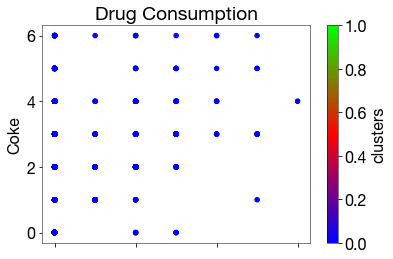

In [117]:
ax = data.plot(kind = 'scatter', x = 'Crack', y = 'Coke', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Crack', ylabel = 'Coke')

[Text(0, 0.5, 'Coke'),
 Text(0.5, 0, 'Mushrooms'),
 Text(0.5, 1.0, 'Drug Consumption')]

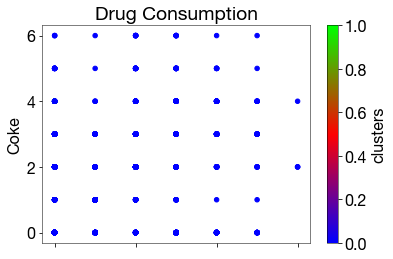

In [118]:
ax = data.plot(kind = 'scatter', x = 'Mushrooms', y = 'Coke', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Mushrooms', ylabel = 'Coke')

In [119]:
#Cluster3 using Hierarchial clustering Complete Linkage

In [120]:
clustering = linkage(x_scaled,method="complete",metric="euclidean")
clusters = fcluster(clustering, 2, criterion = 'maxclust')
clusters = clusters - 1
print(clusters)

[1 1 1 ... 1 1 1]


In [121]:
data['clusters'] = clusters

In [122]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.5415889060633275


In [123]:
#Cluster3 with K-Means

In [124]:
clustering = KMeans(n_clusters = 2, init = 'random', n_init = 1, random_state = 0).fit(x_scaled)
clusters = clustering.labels_
print(clusters)
data['clusters'] = clusters

[0 1 0 ... 1 1 1]


In [125]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.4487703444541595


In [126]:
#Cluster3 with DBSCAN

In [127]:
clustering = DBSCAN(eps = 2, min_samples = 3, metric = "euclidean").fit(x_scaled)
clusters = clustering.labels_
data['clusters'] = clusters

In [128]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.5160039017438653


In [129]:
#cluster4: Using only the drugs

In [130]:
variables = illegal_drugs + Non_illegal
var_indices = [data.columns.get_loc(variable) for variable in variables]
print(var_indices)

[14, 20, 21, 22, 23, 26, 28, 13, 15, 16, 17, 18, 19, 24, 25, 27, 29, 30, 31]


In [131]:
#Standardizing the data
x = data.iloc[:,var_indices]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [132]:
clustering = linkage(x_scaled,method="single",metric="euclidean")
clusters = fcluster(clustering, 2, criterion = 'maxclust')
clusters = clusters - 1
print(clusters)

[0 0 0 ... 0 0 0]


In [133]:
data['clusters'] = clusters

In [134]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.7799966615627284


[Text(0, 0.5, 'Coke'),
 Text(0.5, 0, 'Crack'),
 Text(0.5, 1.0, 'Drug Consumption')]

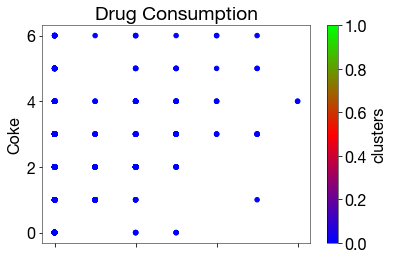

In [135]:
ax = data.plot(kind = 'scatter', x = 'Crack', y = 'Coke', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Crack', ylabel = 'Coke')

[Text(0, 0.5, 'Coke'),
 Text(0.5, 0, 'Mushrooms'),
 Text(0.5, 1.0, 'Drug Consumption')]

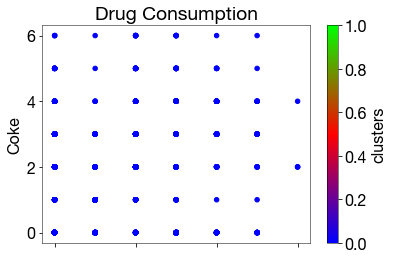

In [136]:
ax = data.plot(kind = 'scatter', x = 'Mushrooms', y = 'Coke', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Mushrooms', ylabel = 'Coke')

[Text(0, 0.5, 'Nicotine'),
 Text(0.5, 0, 'Alcohol'),
 Text(0.5, 1.0, 'Drug Consumption')]

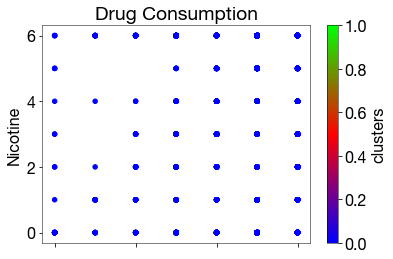

In [137]:
ax = data.plot(kind = 'scatter', x = 'Alcohol', y = 'Nicotine', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Alcohol', ylabel = 'Nicotine')

[Text(0, 0.5, 'Coke'),
 Text(0.5, 0, 'Nicotine'),
 Text(0.5, 1.0, 'Drug Consumption')]

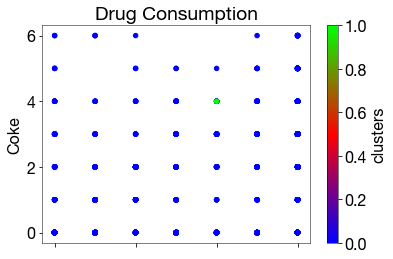

In [138]:
ax = data.plot(kind = 'scatter', x = 'Nicotine', y = 'Coke', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Nicotine', ylabel = 'Coke')

In [139]:
#Cluster4 using Hierarchial clustering Complete Linkage

In [140]:
clustering = linkage(x_scaled,method="complete",metric="euclidean")
clusters = fcluster(clustering, 2, criterion = 'maxclust')
clusters = clusters - 1
print(clusters)

[1 1 1 ... 1 1 1]


In [141]:
data['clusters'] = clusters

In [142]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.7432570016576694


In [143]:
#Cluster4 with K-Means

In [144]:
clustering = KMeans(n_clusters = 2, init = 'random', n_init = 1, random_state = 0).fit(x_scaled)
clusters = clustering.labels_
print(clusters)
data['clusters'] = clusters

[0 1 0 ... 1 1 1]


In [145]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.2684663279061382


In [146]:
#Cluster4 with DBSCAN

In [147]:
clustering = DBSCAN(eps = 2, min_samples = 3, metric = "euclidean").fit(x_scaled)
clusters = clustering.labels_
data['clusters'] = clusters

In [148]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

-0.06633855889724637


In [149]:
#Cluster5: Not using any drugs

In [150]:
variables = data.columns[0:13]
var_indices = [data.columns.get_loc(variable) for variable in variables]
print(var_indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [151]:
#Standardizing the data
x = data.iloc[:,var_indices]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [152]:
#Cluster5 with Hierarchial clustering with Single Linkage

In [153]:
clustering = linkage(x_scaled,method='single',metric="euclidean")
clusters = fcluster(clustering, 2, criterion = 'maxclust')
clusters = clusters - 1
print(clusters)

[0 0 0 ... 0 0 0]


In [154]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

-0.21114670320992815


In [155]:
#Cluster5 with Hierarchial Clustering with Complete Linkage

In [156]:
clustering = linkage(x_scaled,method='complete',metric="euclidean")
clusters = fcluster(clustering, 2, criterion = 'maxclust')
clusters = clusters - 1
print(clusters)

[1 1 1 ... 1 1 1]


In [157]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

-0.21114670320992815


In [158]:
#Cluster 5 with K-Means

In [159]:
clustering = KMeans(n_clusters = 2, init = 'random', n_init = 1, random_state = 0).fit(x_scaled)
clusters = clustering.labels_
print(clusters)
data['clusters'] = clusters

[0 0 0 ... 1 1 1]


In [160]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.15804112591503822


[Text(0, 0.5, 'Nscore'),
 Text(0.5, 0, 'Ascore'),
 Text(0.5, 1.0, 'Drug Consumption')]

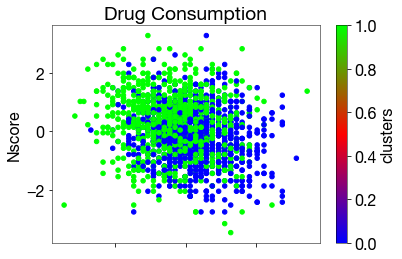

In [161]:
ax = data.plot(kind = 'scatter', x = 'Ascore', y = 'Nscore', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Ascore', ylabel = 'Nscore')

[Text(0, 0.5, 'Oscore'),
 Text(0.5, 0, 'Ascore'),
 Text(0.5, 1.0, 'Drug Consumption')]

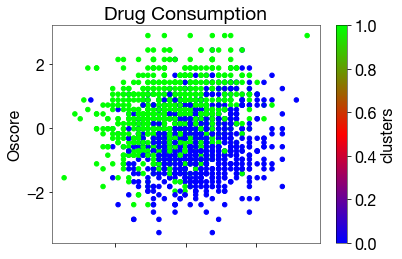

In [162]:
ax = data.plot(kind = 'scatter', x = 'Ascore', y = 'Oscore', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Ascore', ylabel = 'Oscore')

[Text(0, 0.5, 'Oscore'),
 Text(0.5, 0, 'Age'),
 Text(0.5, 1.0, 'Drug Consumption')]

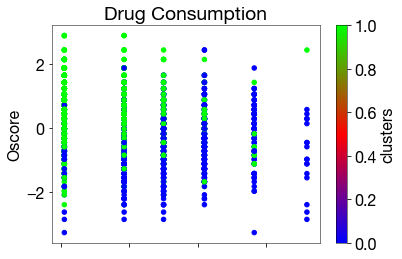

In [163]:
ax = data.plot(kind = 'scatter', x = 'Age', y = 'Oscore', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Age', ylabel = 'Oscore')

In [164]:
#Cluster5 with DBSCAN

In [165]:
clustering = DBSCAN(eps = 2, min_samples = 3, metric = "euclidean").fit(x_scaled)
clusters = clustering.labels_
data['clusters'] = clusters

In [166]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

-0.11510965619210076


In [167]:
#Cluster6: Using Personality traits

In [168]:
variables = data.columns[6:13]
var_indices = [data.columns.get_loc(variable) for variable in variables]
print(var_indices)

[6, 7, 8, 9, 10, 11, 12]


In [169]:
#Standardizing the data
x = data.iloc[:,var_indices]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [170]:
#Cluster6 with Hierarchial clustering with Single Linkage

In [171]:
clustering = linkage(x_scaled,method="single",metric="euclidean")
clusters = fcluster(clustering, 2, criterion = 'maxclust')
clusters = clusters - 1
print(clusters)

[0 0 0 ... 0 0 0]


In [172]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

-0.32290072471567954


In [173]:
#Cluster6 with Hierarchial Clustering with Complete Linkage

In [174]:
clustering = linkage(x_scaled,method='complete',metric="euclidean")
clusters = fcluster(clustering, 2, criterion = 'maxclust')
clusters = clusters - 1
print(clusters)

[1 1 0 ... 0 0 1]


In [175]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

-0.32290072471567954


In [176]:
#Cluster6 with K-Means

In [177]:
clustering = KMeans(n_clusters = 2, init = 'random', n_init = 1, random_state = 0).fit(x_scaled)
clusters = clustering.labels_
print(clusters)
data['clusters'] = clusters

[1 1 1 ... 0 0 0]


[Text(0, 0.5, 'Nscore'),
 Text(0.5, 0, 'Ascore'),
 Text(0.5, 1.0, 'Drug Consumption')]

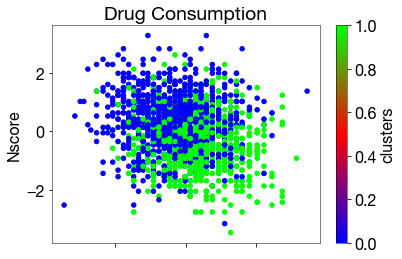

In [178]:
ax = data.plot(kind = 'scatter', x = 'Ascore', y = 'Nscore', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Ascore', ylabel = 'Nscore')

[Text(0, 0.5, 'Nscore'),
 Text(0.5, 0, 'Oscore'),
 Text(0.5, 1.0, 'Drug Consumption')]

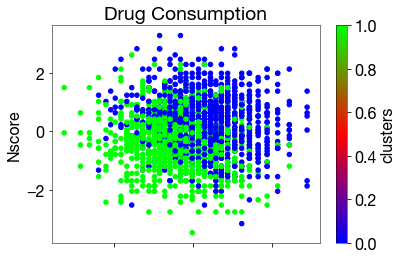

In [179]:
ax = data.plot(kind = 'scatter', x = 'Oscore', y = 'Nscore', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Oscore', ylabel = 'Nscore')

[Text(0, 0.5, 'Impulsive'),
 Text(0.5, 0, 'Oscore'),
 Text(0.5, 1.0, 'Drug Consumption')]

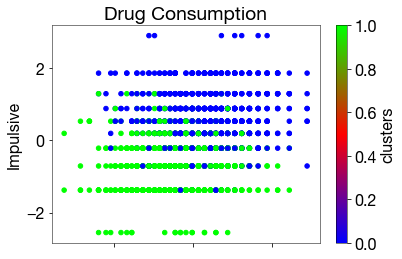

In [180]:
ax = data.plot(kind = 'scatter', x = 'Oscore', y = 'Impulsive', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Oscore', ylabel = 'Impulsive')

In [181]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.1898276389135005


In [182]:
#Cluster6 with DBSCAN

In [183]:
clustering = DBSCAN(eps = 2, min_samples = 3, metric = "euclidean").fit(x_scaled)
clusters = clustering.labels_
data['clusters'] = clusters

In [184]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.3122595933194069


In [185]:
#Cluster7: Using Personality traits and Non_illegal drugs

In [186]:
variables = Non_illegal
var_indices = [data.columns.get_loc(variable) for variable in variables] + [6,7,8,9,10,11,12]
print(var_indices)

[13, 15, 16, 17, 18, 19, 24, 25, 27, 29, 30, 31, 6, 7, 8, 9, 10, 11, 12]


In [187]:
#Standardizing the data
x = data.iloc[:,var_indices]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [188]:
#Cluster7 with Hierarchial Clustering with Single Linkage

In [189]:
clustering = linkage(x_scaled,method="single",metric="euclidean")
clusters = fcluster(clustering, 2, criterion = 'maxclust')
clusters = clusters - 1
print(clusters)

[0 0 0 ... 0 0 0]


In [190]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.2200681697633267


[Text(0, 0.5, 'Nicotine'),
 Text(0.5, 0, 'Age'),
 Text(0.5, 1.0, 'Drug Consumption')]

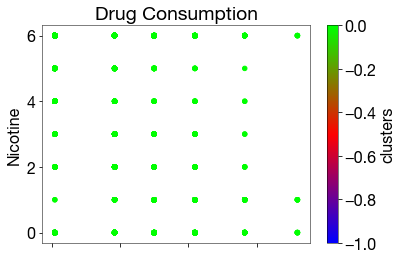

In [191]:
ax = data.plot(kind = 'scatter', x = 'Age', y = 'Nicotine', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Age', ylabel = 'Nicotine')

[Text(0, 0.5, 'Alcohol'),
 Text(0.5, 0, 'Ascore'),
 Text(0.5, 1.0, 'Drug Consumption')]

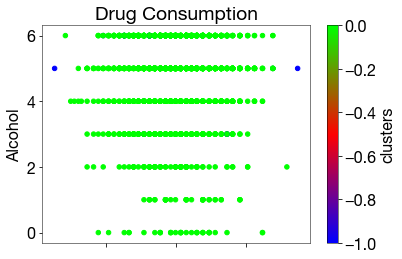

In [192]:
ax = data.plot(kind = 'scatter', x = 'Ascore', y = 'Alcohol', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Ascore', ylabel = 'Alcohol')

[Text(0, 0.5, 'Nscore'),
 Text(0.5, 0, 'Ascore'),
 Text(0.5, 1.0, 'Drug Consumption')]

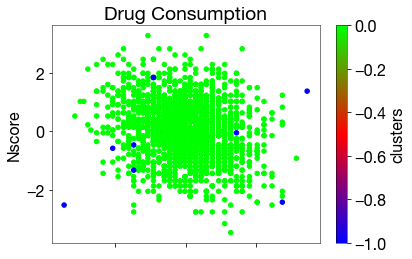

In [193]:
ax = data.plot(kind = 'scatter', x = 'Ascore', y = 'Nscore', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Ascore', ylabel = 'Nscore')

[Text(0, 0.5, 'Amyl'),
 Text(0.5, 0, 'Nicotine'),
 Text(0.5, 1.0, 'Drug Consumption')]

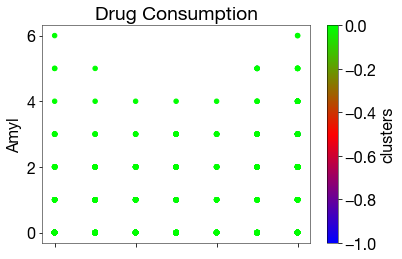

In [194]:
ax = data.plot(kind = 'scatter', x = 'Nicotine', y = 'Amyl', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Nicotine', ylabel = 'Amyl')

[Text(0, 0.5, 'Impulsive'),
 Text(0.5, 0, 'Oscore'),
 Text(0.5, 1.0, 'Drug Consumption')]

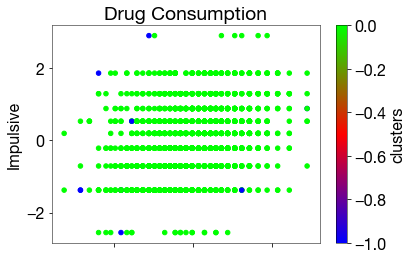

In [195]:
ax = data.plot(kind = 'scatter', x = 'Oscore', y = 'Impulsive', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Oscore', ylabel = 'Impulsive')

In [196]:
#Cluster7 with Hierarchial Clustering with Complete Linkage

In [197]:
clustering = linkage(x_scaled,method='complete',metric="euclidean")
clusters = fcluster(clustering, 2, criterion = 'maxclust')
clusters = clusters - 1
print(clusters)

[1 1 1 ... 1 1 1]


In [198]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.2200681697633267


In [199]:
#Cluster7 with K-Means

In [200]:
clustering = KMeans(n_clusters = 2, init = 'random', n_init = 1, random_state = 0).fit(x_scaled)
clusters = clustering.labels_
print(clusters)
data['clusters'] = clusters

[0 1 0 ... 1 1 1]


In [201]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.1663782954936895


In [202]:
#Cluster7 with DBSCAN

In [203]:
clustering = DBSCAN(eps = 2, min_samples = 3, metric = "euclidean").fit(x_scaled)
clusters = clustering.labels_
data['clusters'] = clusters

In [204]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

-0.211881563006982


In [205]:
#Cluster8: Using Personality traits and Illegal drugs

In [206]:
variables = illegal_drugs
var_indices = [data.columns.get_loc(variable) for variable in variables] + [6,7,8,9,10,11,12]
print(var_indices)

[14, 20, 21, 22, 23, 26, 28, 6, 7, 8, 9, 10, 11, 12]


In [207]:
#Standardizing the data
x = data.iloc[:,var_indices]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [208]:
#Cluster8 with Hierarchial Clustering with Single Linkage

In [209]:
clustering = linkage(x_scaled,method="single",metric="euclidean")
clusters = fcluster(clustering, 2, criterion = 'maxclust')
clusters = clusters - 1
print(clusters)

[0 0 0 ... 0 0 0]


In [210]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

-0.2673306540216515


In [211]:
#Cluster8 with Hierarchial Clustering with Complete Linkage

In [212]:
clustering = linkage(x_scaled,method='complete',metric="euclidean")
clusters = fcluster(clustering, 2, criterion = 'maxclust')
clusters = clusters - 1
print(clusters)

[1 1 1 ... 1 1 1]


In [213]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

-0.2673306540216515


In [214]:
#Cluster8 with K-Means

In [215]:
clustering = KMeans(n_clusters = 2, init = 'random', n_init = 1, random_state = 0).fit(x_scaled)
clusters = clustering.labels_
print(clusters)
data['clusters'] = clusters

[0 1 0 ... 1 1 1]


In [216]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

0.2401118477537548


[Text(0, 0.5, 'Coke'),
 Text(0.5, 0, 'Ascore'),
 Text(0.5, 1.0, 'Drug Consumption')]

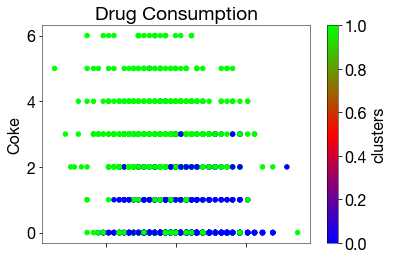

In [217]:
ax = data.plot(kind = 'scatter', x = 'Ascore', y = 'Coke', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Ascore', ylabel = 'Coke')

[Text(0, 0.5, 'Nscore'),
 Text(0.5, 0, 'Ascore'),
 Text(0.5, 1.0, 'Drug Consumption')]

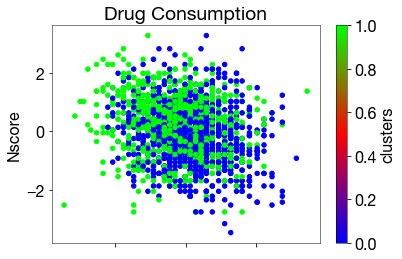

In [218]:
ax = data.plot(kind = 'scatter', x = 'Ascore', y = 'Nscore', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Ascore', ylabel = 'Nscore')

[Text(0, 0.5, 'Coke'),
 Text(0.5, 0, 'Crack'),
 Text(0.5, 1.0, 'Drug Consumption')]

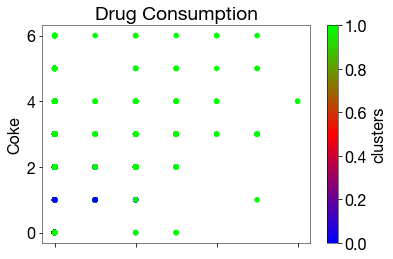

In [219]:
ax = data.plot(kind = 'scatter', x = 'Crack', y = 'Coke', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Crack', ylabel = 'Coke')

[Text(0, 0.5, 'Mushrooms'),
 Text(0.5, 0, 'Oscore'),
 Text(0.5, 1.0, 'Drug Consumption')]

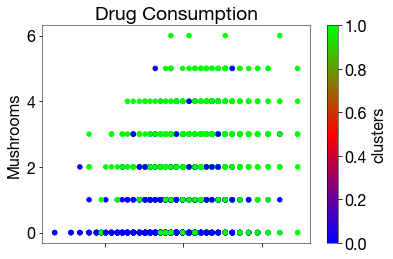

In [220]:
ax = data.plot(kind = 'scatter', x = 'Oscore', y = 'Mushrooms', c = 'clusters', colormap = plt.cm.brg)
ax.set(title = 'Drug Consumption', xlabel = 'Oscore', ylabel = 'Mushrooms')

In [221]:
#Cluster8 with DBSCAN

In [222]:
clustering = DBSCAN(eps = 2, min_samples = 3, metric = "euclidean").fit(x_scaled)
clusters = clustering.labels_
data['clusters'] = clusters

In [223]:
#Silhouette coefficient
print(metrics.silhouette_score(x_scaled, data['clusters'], metric = "euclidean"))

-0.11209916794288363
